# **Evaluation of ML Models**

---

## Project Overview

This p ls**, focuses on developing and evaluating machine learning models to predict credit card approvals. Given a dataset with various features, including demographics and financial information, the task is to preprocess the data, train models, and evaluate their performance. We use a range of machine learning techniques to understand the factors influencing approval decisions and ensure the models are fair and interpretable.

Our approach includes a comprehensive exploration of the data, feature engineering, and model training using Logistic Regression and XGBoost. Additionally, model interpretability techniques, such as SHAP values, are applied to ensure we understand the predictions and identify any potential biases.

---

## Agenda

1. **Data Exploration**
   - Perform an initial examination of the dataset.
   - Analyze feature distributions, missing values, and relationships among variables.
   - Investigate class balance for the target variable.

2. **Data Preparation**
   - Encode categorical variables using one-hot and label encoding.
   - Standardize numerical features to optimize model performance.
   - Split data into training and testing sets.

3. **Model Training**
   - **Logistic Regression**: Train a linear model for baseline performance and interpretability.
   - **XGBoost**: Train a gradient boosting model for enhanced predictive power and fine-grained interpretability.

4. **Model Interpretation**
   - Evaluate model performance using metrics such as accuracy, precision, recall, and F1 score.
   - Apply SHAP (SHapley Additive exPlanations) to interpret feature importance and visualize the impact of each feature on predictions.
   - Assess fairness and bias in model predictions through statistical parity and other metrics.

---

## Author

**Mohamed Ezzat**

---



In [2]:
# Import Required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
import joblib
import matplotlib.pyplot as plt
# Load dataset
df = pd.read_csv('credit_card_train.csv')
df.head()


,Num_Children,Gender,Income,Own_Car,Own_Housing,Credit_Card_Issuing
0,1,Male,40690,No,Yes,Denied
1,2,Female,75469,Yes,No,Denied
2,1,Male,70497,Yes,Yes,Approved
3,1,Male,61000,No,No,Denied
4,1,Male,56666,Yes,Yes,Denied


## Data Exploration 

Percentage of Approved vs Denied Credit Cards: 63.06%
Percentage of Male Approved vs Female Approved Credit Cards: 290.24%
Percentage of Approved with Own Car vs Without Car: 336.25%
Percentage of Approved with Own House vs Without House: 101.74%


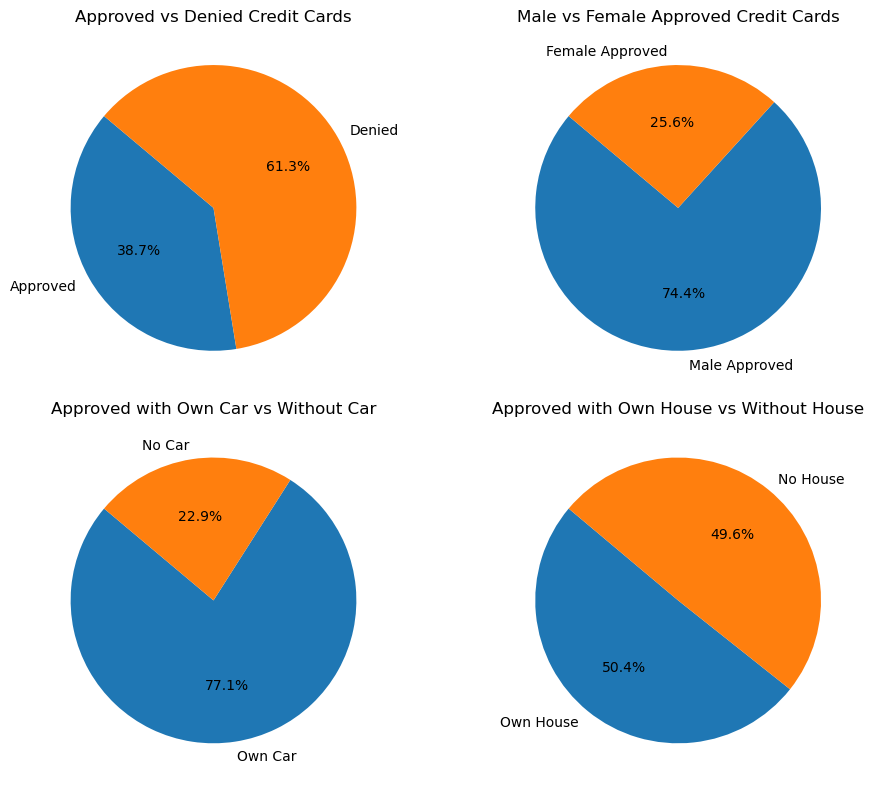

In [4]:
import matplotlib.pyplot as plt

# Calculate totals
Approved_credit = df[df['Credit_Card_Issuing'] == 'Approved']
Denied_credit = df[df['Credit_Card_Issuing'] == 'Denied']

Male_Approved = Approved_credit[Approved_credit['Gender'] == 'Male'].shape[0]
Female_Approved = Approved_credit[Approved_credit['Gender'] == 'Female'].shape[0]

Own_Car = Approved_credit[Approved_credit['Own_Car'] == 'Yes'].shape[0]
No_Car = Approved_credit[Approved_credit['Own_Car'] == 'No'].shape[0]

Own_house = Approved_credit[Approved_credit['Own_Housing'] == 'Yes'].shape[0]
No_house = Approved_credit[Approved_credit['Own_Housing'] == 'No'].shape[0]

approved_vs_denied_ratio = Approved_credit.shape[0] / Denied_credit.shape[0]
male_vs_female_approved_ratio = Male_Approved / Female_Approved
own_car_ratio = Own_Car / No_Car
own_house_ratio = Own_house / No_house

print(f'Percentage of Approved vs Denied Credit Cards: {approved_vs_denied_ratio * 100:.2f}%')
print(f'Percentage of Male Approved vs Female Approved Credit Cards: {male_vs_female_approved_ratio * 100:.2f}%')
print(f'Percentage of Approved with Own Car vs Without Car: {own_car_ratio * 100:.2f}%')
print(f'Percentage of Approved with Own House vs Without House: {own_house_ratio * 100:.2f}%')

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

# Approved vs Denied
axes[0].pie([Approved_credit.shape[0], Denied_credit.shape[0]], labels=['Approved', 'Denied'], autopct='%1.1f%%', startangle=140)
axes[0].set_title('Approved vs Denied Credit Cards')

# Male vs Female Approved
axes[1].pie([Male_Approved, Female_Approved], labels=['Male Approved', 'Female Approved'], autopct='%1.1f%%', startangle=140)
axes[1].set_title('Male vs Female Approved Credit Cards')

# Own Car vs No Car
axes[2].pie([Own_Car, No_Car], labels=['Own Car', 'No Car'], autopct='%1.1f%%', startangle=140)
axes[2].set_title('Approved with Own Car vs Without Car')

# Own House vs No House
axes[3].pie([Own_house, No_house], labels=['Own House', 'No House'], autopct='%1.1f%%', startangle=140)
axes[3].set_title('Approved with Own House vs Without House')

plt.tight_layout()
plt.show()


### Insights from Initial Data Analysis

As shown in the previous four pie charts:

1. **Approved vs Denied Credit Cards**:  
   - We examined the balance in the target variable. Although there are more denied applications than approved ones, the number of approved cases is still substantial. Therefore, we do not have a significant class imbalance, which is beneficial for model training.

2. **Male vs Female Approved**:  
   - The majority of approved credit cards are for male applicants, suggesting that gender may have an influence on approval rates. This could potentially introduce bias into the model, favoring male applicants over female ones.

3. **Approved with Car Ownership**:  
   - A high proportion of approved applicants own a car, which might indicate that car ownership has a positive influence on approval likelihood. This trend could also introduce bias if the model starts relying on this feature too heavily.

4. **Approved with Housing Ownership**:  
   - Unlike car ownership, housing ownership does not show a strong influence on approval rates in the initial analysis. However, we will investigate this further during model training and interpretation to see if this observation holds true when assessing feature importance.

These initial insights provide a foundation for understanding potential biases and influential features, which we will revisit during model building and interpretation.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Num_Children         400000 non-null  int64 
 1   Gender               400000 non-null  object
 2   Income               400000 non-null  int64 
 3   Own_Car              400000 non-null  object
 4   Own_Housing          400000 non-null  object
 5   Credit_Card_Issuing  400000 non-null  object
dtypes: int64(2), object(4)
memory usage: 18.3+ MB


In [7]:
df.describe(include='all')

,Num_Children,Gender,Income,Own_Car,Own_Housing,Credit_Card_Issuing
count,400000.000000,400000,400000.000000,400000,400000,400000
unique,NaN,2,NaN,2,2,2
top,NaN,Male,NaN,Yes,No,Denied
freq,NaN,200295,NaN,280375,239482,245301
mean,2.000892,NaN,72517.997500,NaN,NaN,NaN
std,1.410704,NaN,22955.502862,NaN,NaN,NaN
min,0.000000,NaN,30000.000000,NaN,NaN,NaN
25%,1.000000,NaN,53336.000000,NaN,NaN,NaN
50%,2.000000,NaN,72077.000000,NaN,NaN,NaN
75%,3.000000,NaN,90669.000000,NaN,NaN,NaN


In [8]:
df.isna().sum()

Num_Children           0
Gender                 0
Income                 0
Own_Car                0
Own_Housing            0
Credit_Card_Issuing    0
dtype: int64

## Data Preparation 

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    # One-hot encoding for Gender (nominal data)
    df = pd.get_dummies(df, columns=['Gender'])
    df[['Gender_Female', 'Gender_Male']] = df[['Gender_Female', 'Gender_Male']].astype(int)
    
    # Label-encoding (ordinal data)
    df['Own_Car'] = df['Own_Car'].map({'Yes': 1, 'No': 0})
    df['Own_Housing'] = df['Own_Housing'].map({'Yes': 1, 'No': 0})
    df['Credit_Card_Issuing'] = df['Credit_Card_Issuing'].map({'Approved': 1, 'Denied': 0})
    
    # Split features and target
    X = df.drop(columns='Credit_Card_Issuing')
    y = df['Credit_Card_Issuing']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardization
    scaler = StandardScaler()
    X_train[['Num_Children', 'Income']] = scaler.fit_transform(X_train[['Num_Children', 'Income']])
    X_test[['Num_Children', 'Income']] = scaler.transform(X_test[['Num_Children', 'Income']])
    
    
    return X_train, X_test, y_train, y_test


In [11]:
X_train, X_test, y_train, y_test = preprocess_data(df)

In [12]:
X_train.head()

,Num_Children,Income,Own_Car,Own_Housing,Gender_Female,Gender_Male
242245,-0.708886,0.451857,1,0,1,0
288918,0.708971,-1.308929,0,1,0,1
105103,-1.417815,1.598288,0,0,0,1
63504,0.000042,0.384569,1,0,0,1
239180,0.000042,-0.428601,1,0,1,0


In [13]:
y_train.head()

242245    0
288918    0
105103    1
63504     1
239180    0
Name: Credit_Card_Issuing, dtype: int64

### Evaluation Metrics
- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**
- **Mean Squared Error (MSE)**

### Fairness and Bias Analysis
- **Statistical Parity**
- **True Positive Rate (TPR)**
  - By Gender
  - By Car Ownership
- **False Positive Rate (FPR)**
  - By Gender

### Model Interpretability
- **SHAP (SHapley Additive exPlanations)**
  - Global SHAP Summary Plot
  - Waterfall Plot for S
- **Model Saving**


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error
import shap
import joblib  # Import joblib for saving the model

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on train and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics for training and testing
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Mean Squared Error
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print(f"Train Accuracy: {train_accuracy:.5f}")
    print(f"Test Accuracy: {test_accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1 Score: {f1:.5f}")
    print(f"Train MSE: {mse_train:.5f}")
    print(f"Test MSE: {mse_test:.5f}")
    
    # Fairness and Bias Analysis
    male_indices = X_test['Gender_Male'] == 1
    female_indices = X_test['Gender_Female'] == 1
    car_indices = X_test['Own_Car'] == 1
    no_car_indices = X_test['Own_Car'] == 0

    # Statistical Parity
    male_approved = sum(y_test_pred[male_indices] == 1) / sum(male_indices)
    female_approved = sum(y_test_pred[female_indices] == 1) / sum(female_indices)
    statistical_parity = male_approved - female_approved

    # True Positive Rate (TPR) by Gender
    male_tpr = recall_score(y_test[male_indices], y_test_pred[male_indices])
    female_tpr = recall_score(y_test[female_indices], y_test_pred[female_indices])

    # True Positive Rate (TPR) by Car Ownership
    car_tpr = recall_score(y_test[car_indices], y_test_pred[car_indices])
    no_car_tpr = recall_score(y_test[no_car_indices], y_test_pred[no_car_indices])

    # False Positive Rate (FPR) by Gender
    male_fpr = (sum((y_test_pred[male_indices] == 1) & (y_test[male_indices] == 0)) / sum(male_indices & (y_test == 0)))
    female_fpr = (sum((y_test_pred[female_indices] == 1) & (y_test[female_indices] == 0)) / sum(female_indices & (y_test == 0)))
    
    # Display Fairness and Bias Metrics
    print(f"Statistical Parity (Male vs Female Approved): {statistical_parity:.5f}")
    print(f"TPR (Male): {male_tpr:.5f}, TPR (Female): {female_tpr:.5f}")
    print(f"TPR (Own Car): {car_tpr:.5f}, TPR (No Car): {no_car_tpr:.5f}")
    print(f"FPR (Male): {male_fpr:.5f}, FPR (Female): {female_fpr:.5f}")
    
    try:
        explainer = shap.Explainer(model, X_train)
    except Exception as e:
        print("Direct SHAP explainer is not supported for this model. Using KernelExplainer instead, which may be slower.")
        explainer = shap.KernelExplainer(model.predict, X_train)
    shap_values = explainer(X_test)     

    # Global SHAP summary plot
    shap.summary_plot(shap_values, X_test)

    # SHAP waterfall plot for a single prediction (first instance as an example)
    print("\nSHAP Waterfall Plot for First Instance")
    shap.plots.waterfall(shap_values[0], max_display=14)  # Adjust max_display as needed for readability

    # Additional SHAP visualizations (e.g., bar plot of absolute SHAP values)
    print("\nSHAP Bar Plot of Feature Importance")
    shap.plots.bar(shap_values.abs.max(0))
    
    # Save the trained model to a file
    model_name = type(model).__name__.replace("Classifier", "").lower()  # Simplified name
    filename = f"{model_name}.pkl"
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")
    
    # Return metrics and the model
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'train_mse': mse_train,
        'test_mse': mse_test,
        'model': model
    }


# Logistic Regression 


Evaluating Logistic Regression


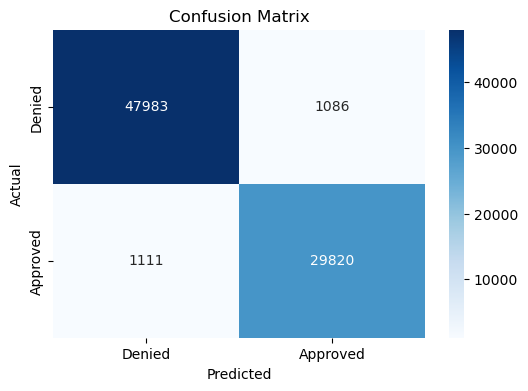

Train Accuracy: 0.97308
Test Accuracy: 0.97254
Precision: 0.96486
Recall: 0.96408
F1 Score: 0.96447
Train MSE: 0.02692
Test MSE: 0.02746
Statistical Parity (Male vs Female Approved): 0.37352
TPR (Male): 0.97717, TPR (Female): 0.92669
TPR (Own Car): 0.96762, TPR (No Car): 0.95217
FPR (Male): 0.03045, FPR (Female): 0.01771


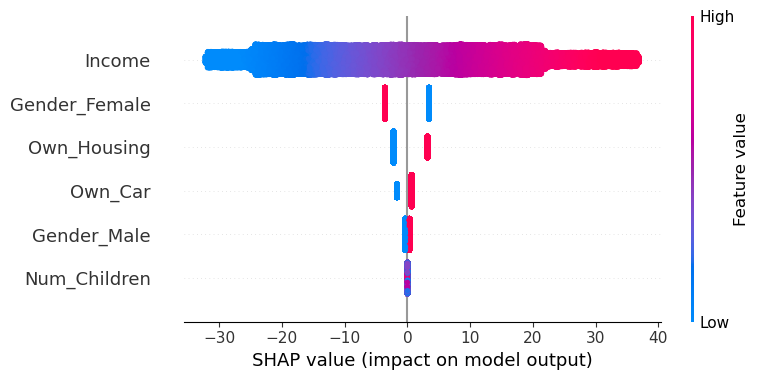


SHAP Waterfall Plot for First Instance


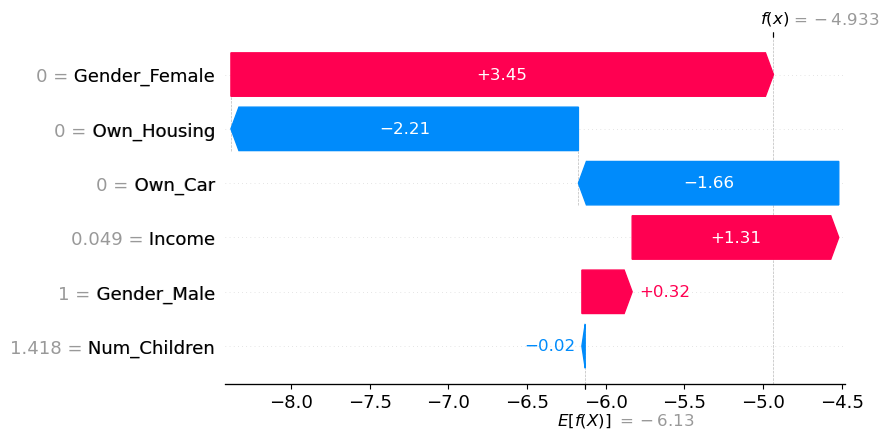


SHAP Bar Plot of Feature Importance


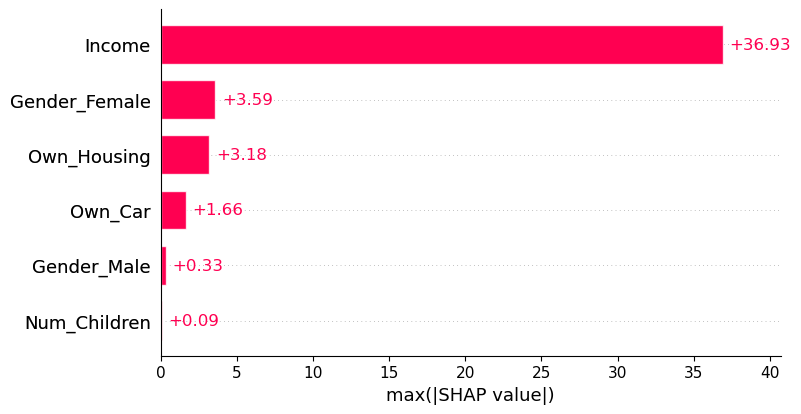

Model saved as logisticregression.pkl


In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize model
logistic_model = LogisticRegression(max_iter=1000)

# Train, evaluate and visualize with SHAP
print("\nEvaluating Logistic Regression")
logistic_results = train_and_evaluate_model(logistic_model, X_train, X_test, y_train, y_test)


### Logistic Regression Model Interpretation

- **Confusion Matrix**:
  - The model performs well with high true positives (Approved) and true negatives (Denied).
  - Few misclassifications are observed, indicating good separation between Approved and Denied classes.

- **Performance Metrics**:
  - **Accuracy**: 97.31% (train), 97.25% (test) — high alignment between train and test accuracy suggests minimal overfitting.
  - **Precision, Recall, F1 Score**: High scores ar  for both precision and recall giving a good f1 score of 96.64%metrics.
  - **Mean Squared Error (MSE)**: Low MSE values for both training an and both values are near suggesting a good generalization of modeldictions.

- **Fairness and Bias**:
  - **Statisticawe used this metric to detect if the model has bias towards specific group but in an unexpected result the males have a larger and better of geeting approved unlike what we observed in the original dataof approval.
  - **True Positive Rates (TPR)**:
    - TPR 7or Males (97.17%) slightly exceeds TPR for Fe indicating that males has better chancemales (92.67%).
    - Similar pattern observed in car ownership, with higher TPR for thos (alligned with data exploration)e who own a car.
  - **False Positive Rates (FPR)**: Males exhibit a slightly higher FPR (3.05%) compared to lower than that of logistic regression females (1.77%).

- **Model Interpretability (SHAP Analysis)**:
  - **Global SHAP Summary**: Income is the most  (Expected as income is directly proportional to credit card)influential feature, with higher incomes increasing the likelihood of approval.
  - **Gender and Housing**:
    - **Gender_inverselyonmaking that being female decrease the chance getting approvedluence in predictions.
    - **Own_Housing** and **Own_Car** factors show moderate impact on the model, affe but in an unexpected result the SHAP analysis shows own_Housing has a better importance than having a car is completly not expected as we observed in original Datacting credit decisions.

  - **SHAP Waterfall Plot**: Visualizes the impact of individual features on the predictictions at a local level.

Overall, the logistic regression model performs well, with slight biases related to gender and car ownership. The SHAP values underscore the impor.lity of model predictions.



Evaluating XGBoost


C:\Users\mohamed.badawi\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:14:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


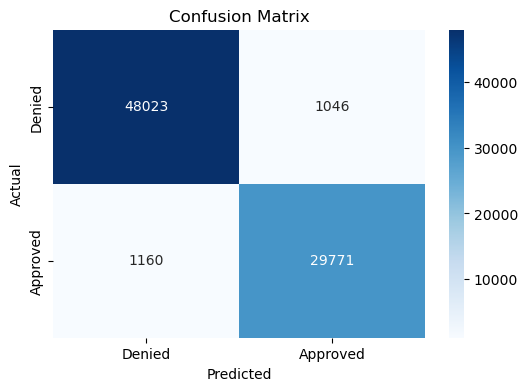

Train Accuracy: 0.97391
Test Accuracy: 0.97242
Precision: 0.96606
Recall: 0.96250
F1 Score: 0.96427
Train MSE: 0.02609
Test MSE: 0.02757
Statistical Parity (Male vs Female Approved): 0.37429
TPR (Male): 0.97608, TPR (Female): 0.92370
TPR (Own Car): 0.96712, TPR (No Car): 0.94695
FPR (Male): 0.03021, FPR (Female): 0.01658


100%|===================| 79782/80000 [03:04<00:00]        

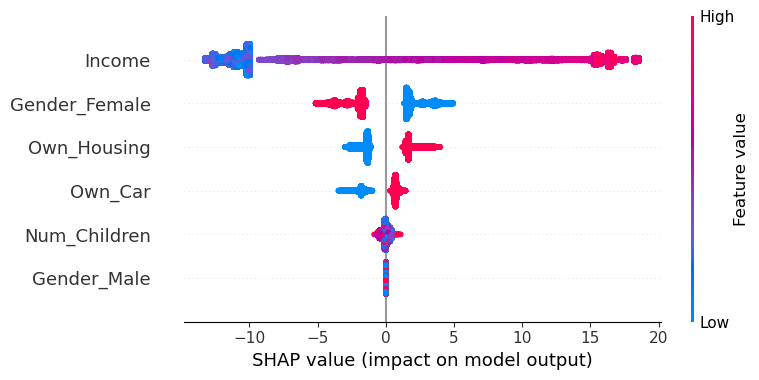


SHAP Waterfall Plot for First Instance


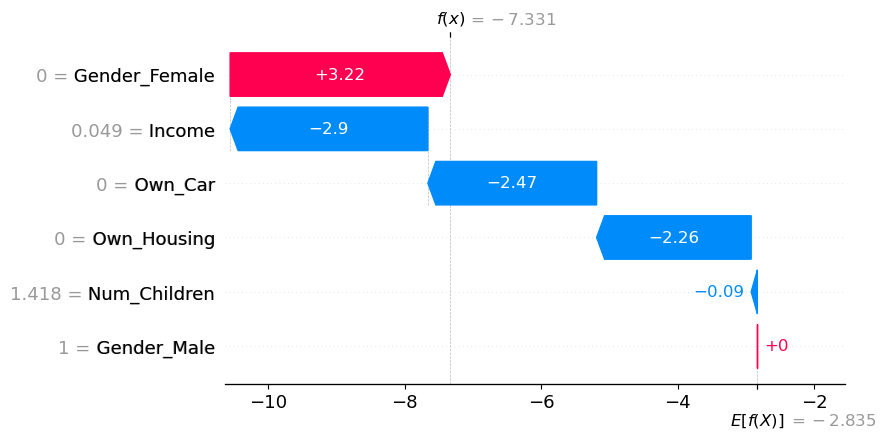


SHAP Bar Plot of Feature Importance


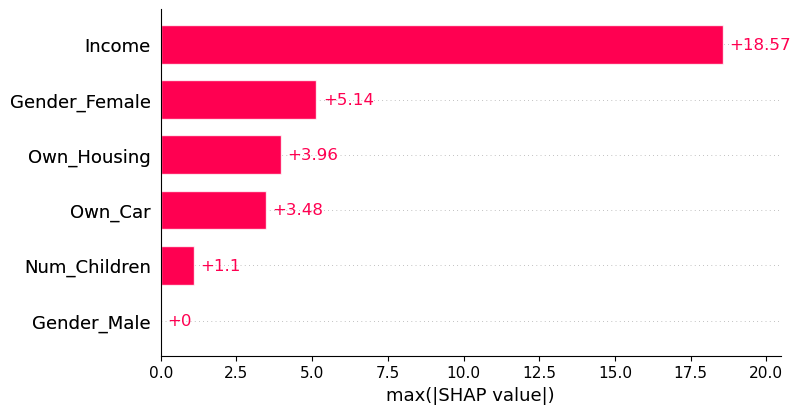

Model saved as xgb.pkl


In [19]:
from xgboost import XGBClassifier

# Initialize model
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train, evaluate and visualize with SHAP
print("\nEvaluating XGBoost")
xgboost_results = train_and_evaluate_model(xgboost_model, X_train, X_test, y_train, y_test)


# XGBoost Model Interpretation

- **Confusion Matrix**:
  - The XGBoost model performs well with high true positives (Approved) and true negatives (Denied).
  - Slightly more misclassifications compared to Logistic Regression, with a slightly higher number of false positives.

- **Performance Metrics**:
  - **Accuracy**: 97.39% (train), 97.24% (test) — similar alignment between train and test accuracy, suggesting minimal overfitting.
  - **Precision, Recall, F1 Score**: Very high scores, with precision at 96.61%, recall at 96.25%, and F1 score of 96.43%, indicating strong performance.
  - **Mean Squared Error (MSE)**: Low MSE values for both training and testing, similar to the Logistic Regression model, showing good generalization.

- **Fairness and Bias**:
  - **Statistical Parity**: Similar to Logistic Regression, males have a higher likelihood of getting approved than females, indicating a potential gender-related bias.
  - **True Positive Rates (TPR)**:
    - TPR for Males (97.61%) remains higher than TPR for Females (92.37%), indicating a persistent bias toward males in approvals.
    - Those who own a car also have a higher TPR, aligning with the data exploration.
  - **False Positive Rates (FPR)**: Similar pattern with slightly higher FPR for males (3.04%) compared to females (1.65%).

- **Model Interpretability (SHAP Analysis)**:
  - **Global SHAP Summary**: Similar to Logistic Regression, **Income** emerges as the most influential feature, with higher incomes increasing the probability of approval.
  - **Gender and Housing**:
    - **Gender_Female** and **Own_Housing** show significant effects, with being female negatively impacting the approval chances.
    - The SHAP values indicate that **Own_Housing** is also an important factor, which was less expected based on initial observations, while **Own_Car** continues to show some influence.
  - **SHAP Waterfall Plot**: Provides a visual representation of individual feature contributions to the predictionvel of complexity in the model.



# Conclusion
Both Logistic Regression and XGBoost models exhibit strong performance with high accuracy and minimal overfitting. However, some key differences are observed:

- **Performance**: Logistic Regression slightly outperforms Logistic Regression in a slightly higher accuracy and lower MSE.
- **Bias**: Both models exhibit a similar pattern of bias towards males and those who own a car, with comparable TPR and FPR distributions.
- **Interpretability**: Both models have  nearlythe same Interpretability acroos the features but at the end they assure the same idea

**Overall**, Both models can be used in prediction because the differences are negligable but we will use Logistic regression as It is slightly better
